In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import moleculetools as mt
import seaborn as sns

sns.set_style(style='whitegrid', rc={'font.family':'sans-serif', 'font.sans-serif':['Helvetica Neue'], 'font.weight':'light', 'font.size':9})
sns.set_context("paper", font_scale=0.8, rc={"font.size":10, "axes.labelsize":6})
rc('font', **{'family':'sans-serif', 'sans-serif':['Helvetica Neue'], 'weight':'light', 'size':10})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markeredgewidth'] = 0
plt.rcParams['lines.markersize'] = 4.5
plt.rcParams['lines.markeredgecolor'] = (0, 0, 0, 0)

%matplotlib inline

#print(plt.rcParams.keys())

# Style and function definitions

In [24]:
def read_palette(palette_file):
    color_dict = {}
    with open(palette_file, 'r') as open_file:
        for line in open_file.readlines():
            if line[0] == '$':
                color_name = line.split(':')[0][1:]
                rgba_str = line.split(': rgba')[1][1:-3]
                rgb_values = rgba_str.split(', ')[:-1]
                norm_rgb_values = [float(x)/255 for x in rgb_values]
                color_dict[color_name] = norm_rgb_values
    return color_dict
                

colors = read_palette('palettes.scss')

sys_colors = {
    's':colors['color7'],
    'se':colors['color9'],
    'as':colors['color5'],
    'asn':colors['color4'],
    'p':colors['color3'],
    'pn':colors['color2'],
}

In [25]:
def cm2inch(value):
    return value/2.54

def new_figure(height=5, type='body'):
    if type == 'body':
        width = 10.75
    elif type == 'margin':
        width = 5
    elif type == 'wide':
        width = 16.5
    else:
        width = 10.75
    fig = plt.figure(figsize=(cm2inch(width), cm2inch(height)))
    fig.set_tight_layout(True)
    return fig

def tuftefy(ax):
    ax.legend(frameon=False) # remove legend outlines
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    #ax.spines["bottom"].set_color('grey')
    #ax.grid(color="w", alpha=0.5)
    ax.get_yaxis().grid(False)
    ax.get_xaxis().grid(False)
    ax.tick_params(axis='both', which='major', pad=0)
    ax.edgecolor = 1
    ax.edgewidth = 0.5
    
def save_figure(figure, name):
    figure.savefig('../images/{}'.format(name), dpi=300)

# Sulflower stability

In [26]:
edf = pd.read_csv("/Users/oscar/Dropbox/s3/flowers/sulflower-stabilities/TABLE", delim_whitespace=True)
edf

,file,scf_energy,scf_zpve,enthalpy,ts,free_energy
0,s05,-1.487611e+06,-1.487569e+06,-1.487562e+06,30.413498,-1.487592e+06
1,s06,-1.785226e+06,-1.785174e+06,-1.785165e+06,33.293766,-1.785199e+06
2,s07,-2.082821e+06,-2.082760e+06,-2.082750e+06,35.991429,-2.082786e+06
3,s08,-2.380426e+06,-2.380356e+06,-2.380344e+06,39.693734,-2.380384e+06
4,s09,-2.677983e+06,-2.677904e+06,-2.677891e+06,43.242927,-2.677934e+06
5,s10,-2.975500e+06,-2.975413e+06,-2.975399e+06,45.791243,-2.975445e+06
6,s11,-3.273012e+06,-3.272916e+06,-3.272901e+06,48.507103,-3.272949e+06
7,s12,-3.570541e+06,-3.570436e+06,-3.570419e+06,51.980995,-3.570471e+06


No handles with labels found to put in legend.


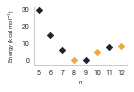

In [27]:
n0 = [5, 6, 7, 9, 11]
energies0 = [30, 15, 6, 0, 7.5]

n1 = [8, 10, 12]
energies1 = [0, 4.8, 8.5]

f = new_figure(height=3.5, type='margin')

ax = sns.scatterplot(x=n0, y=energies0, color=colors['color1'], marker='D', edgecolor=None)
ax = sns.scatterplot(x=n1, y=energies1, color=colors['color8'], marker='D', edgecolor=None)

ax.set_yticks([0, 10, 20, 30])
ax.set_xticks(range(5, 13))
ax.set_xlabel('n')
ax.set_ylabel(r'Energy (kcal mol$^{-1}$)')
tuftefy(ax)

save_figure(f, 'sulflower-strain.pdf')

# Stability study

In [10]:
edf = pd.read_csv("/Users/oscar/Dropbox/s3/flowers/stabilities/TABLE", delim_whitespace=True)
edf.head()

,file,scf_energy,scf_zpve,enthalpy,ts,free_energy
0,as-ring,-1.499876e+06,-1.499835e+06,-1.499831e+06,21.760143,-1.499853e+06
1,as,-1.402793e+06,-1.402793e+06,-1.402792e+06,11.995470,-1.402804e+06
2,as08,-1.160505e+07,-1.160499e+07,-1.160498e+07,46.770785,-1.160502e+07
3,as10,-1.450628e+07,-1.450620e+07,-1.450619e+07,56.694846,-1.450624e+07
4,as12,-1.740752e+07,-1.740742e+07,-1.740740e+07,64.999933,-1.740747e+07


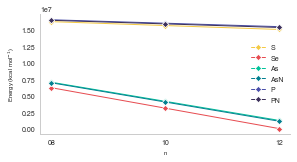

In [11]:
zero = np.zeros(3)

energies = {
    'S':zero,
    'Se':zero,
    'As':zero,
    'AsN':zero,
    'P':zero,
    'PN':zero
}

for key in energies.keys():
    regex_string = '^{system}[0-9]{{2}}$'.format(system=key.lower())
    energies[key] = edf[edf['file'].str.contains(regex_string, regex=True)]['free_energy'].to_numpy()

min_energy = sorted(sum([list(value) for value in energies.values()], []))[0]
    
x = [1, 2, 3]
f = new_figure(height=6, type='body')

for family in energies.keys():
    ax = sns.lineplot(x=x, y=energies[family] - min_energy, color=sys_colors[family.lower()],
                      label=family, marker='D')

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['08', '10', '12'])
ax.set_xlabel('n')
ax.set_ylabel(r'Energy (kcal mol$^{-1}$)')
tuftefy(ax)

save_figure(f, 'sunflower-stability.pdf')

# Bond length study

In [12]:
bond_path = "/Users/oscar/Dropbox/s3/flowers/bond-lengths/"

def get_atom_categories(mol_id):
    """
    Identifies the category of each atom in a sulflower structure, dividing them in:
    - X0 atom in the inside ring
    - X1: outside heteroatom
    - X2: atom between two X1 and an X0
    """
    els, coords = mt.read_xyz(bond_path + mol_id + '.xyz')
    structure = mt.Structure(els, coords)
    structure.find_bonds()
    
    atom_list = list(range(structure.natoms))
    atom_categories = {}
    
    # Identify atoms that are bonded to only 2 other atoms: these are X1
    atom_occurrences = [bond['atoms'] for bond in structure.bonds]
    atom_occurrences = list(sum(atom_occurrences, ()))
    
    for atom in range(structure.natoms):
        appearances = atom_occurrences.count(atom)
        if appearances == 2:
            atom_categories[atom] = 'X1'
            atom_list.remove(atom)
        else:
            atom_categories[atom] = None
        
    # Identify which of the remaining atoms are bonded to X1 atoms
    x1_atoms = [atom for atom in atom_categories.keys() if atom_categories[atom] == 'X1']
    for atom in atom_list:
        bonded_atoms = [bond['atoms'] for bond in structure.bonds if atom in bond['atoms']]
        bonded_atoms = set(sum(bonded_atoms, ()))
        if any(atom in x1_atoms for atom in bonded_atoms):
            atom_categories[atom] = 'X2'
        else:
            atom_categories[atom] = 'X0'
        
    return atom_categories

def get_bond_df(mol_id):
    """
    Identifies the category of each bond in a sulflower structure:
    - O: outside bond between an X1 and an X2
    - M: middle bond between an X0 and an X1
    - I: inside bond between X0s
    """
    els, coords = mt.read_xyz(bond_path + mol_id + '.xyz')
    structure = mt.Structure(els, coords)
    structure.find_bonds()
    bond_types = {}
    for bond in structure.bonds:
        bond_types.setdefault(bond['elements'], []).append(bond)
    df = pd.DataFrame(structure.bonds)
    
    cats = get_atom_categories(mol_id)
    df['atom_types'] = df['atoms'].apply(lambda pair:(cats[pair[0]], cats[pair[1]]))
    bond_type_dict = {('X0', 'X0'):'I', ('X0', 'X2'):'M', ('X1', 'X2'):'O'}
    df['bond_types'] = df['atom_types'].apply(lambda atom_types:bond_type_dict[tuple(sorted(atom_types))])
    
    return df

def get_bond_stats(mol_id):
    df = get_bond_df(mol_id)
    df = df[df['elements'] != ('C', 'H')] # Quick fix to prevent bonds with H in rings
    means = df.groupby('bond_types').mean()
    stds = df.groupby('bond_types').std()
    tuple_list = list(zip(means['distance'], stds['distance']))
    distance_list = list(sum(tuple_list, ()))
    rounded_list = [np.around(x, 3) for x in distance_list]
    return rounded_list

def get_system_stats(sys_id):
    n_petals = ['ring', '08', '10', '12']
    mols = [x.format(sys_id) for x in ['{}-ring', '{}08', '{}10', '{}12']]
    for i, mol in enumerate(mols):
        line = "& {} & {:.3f} & {:.3f} & {:.3f} & {:.3f} & {:.3f} & {:.3f} \\\\".format(n_petals[i], *get_bond_stats(mol))
        print(line)
    
get_system_stats('p')

& ring & 1.467 & nan & 1.359 & 0.000 & 1.794 & 0.001 \\
& 08 & 1.410 & 0.048 & 1.445 & 0.000 & 1.764 & 0.006 \\
& 10 & 1.431 & 0.000 & 1.471 & 0.000 & 1.736 & 0.000 \\
& 12 & 1.429 & 0.045 & 1.462 & 0.002 & 1.747 & 0.005 \\


In [13]:
bonds08 = get_bond_df('as08')
bonds10 = get_bond_df('as10')

bins = np.linspace(1.35, 1.95, 10)
alpha = 0.7

f = new_figure(height=5, type='margin')
ax = sns.distplot(a=bonds08['distance'], bins=bins, color=colors['black'], kde=False, rug=True, hist=True, hist_kws=dict(alpha=alpha))
ax = sns.distplot(a=bonds10['distance'], bins=bins, color=colors['d_orange'], kde=False, rug=True, hist=True, hist_kws=dict(alpha=alpha))
#ax = sns.distplot(a=bonds['distance'][bonds['elements'] == ('C', 'C')], bins=5, color=colors['black'], kde=True, rug=True, hist=False)
#ax = sns.distplot(a=bonds['distance'][bonds['elements'] == ('C', 'As')], bins=5, color=colors['l_orange'], kde=True, rug=True, hist=False)
tuftefy(ax)

save_figure(f, 'hist-test.pdf')

KeyError: 'black'

<Figure size 141.732x141.732 with 0 Axes>

In [8]:
def distplot_with_hue(data=None, x=None, hue=None, row=None, col=None, legend=True, **kwargs):
    _, bins = np.histogram(data[x].dropna())
    g = sns.FacetGrid(data, hue=hue, row=row, col=col)
    g.map(sns.distplot, x, **kwargs)
    if legend and (hue is not None) and (hue not in [x, row, col]):
        g.add_legend(title=hue) 

<Figure size 141.732x141.732 with 0 Axes>

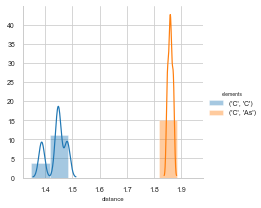

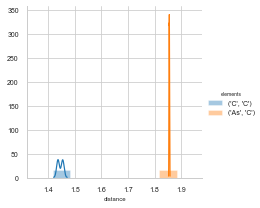

In [9]:
f = new_figure(height=5, type='margin')
ax = distplot_with_hue(data=bonds08, x='distance', hue='elements', bins=bins)
ax = distplot_with_hue(data=bonds10, x='distance', hue='elements', bins=bins)
#ax = sns.distplot(a=bonds['distance'][bonds['elements'] == ('C', 'C')], bins=5, color=colors['black'], kde=True, rug=True, hist=False)
#ax = sns.distplot(a=bonds['distance'][bonds['elements'] == ('C', 'As')], bins=5, color=colors['l_orange'], kde=True, rug=True, hist=False)
#tuftefy(ax)

In [14]:
bonds08.head()

,atoms,elements,distance,label
0,"(0, 1)","(C, C)",1.481319,1
1,"(0, 7)","(C, C)",1.387611,0
2,"(0, 12)","(C, C)",1.448541,0
3,"(1, 2)","(C, C)",1.387611,0
4,"(1, 11)","(C, C)",1.448258,0


In [13]:
bonds08.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
atoms       32 non-null object
elements    32 non-null object
distance    32 non-null float64
label       32 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ KB


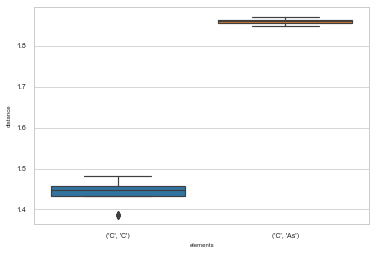

In [12]:
sns.boxplot(data=bonds08, x='elements', y='distance')